In [1]:
import torch 
import pandas as pd
import numpy as np
from amlvae.models.VAE import VAE

import shap
from matplotlib import pyplot as plt
import gseapy as gp
import umap 
import seaborn as sbn

from sklearn.cluster import OPTICS, DBSCAN, HDBSCAN

from amlvae.models.MLP import MLP

import captum
from captum.attr import IntegratedGradients

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.load('../output/vae_l12_4-24-25.pt', weights_only=False)

model = model.to(device)
model = model.eval()

expr = pd.read_csv('../data/aml_expr.csv')
X = expr.iloc[:, 1:].values
X = torch.tensor(X, dtype=torch.float32, device=device)


In [38]:
xhat = model.decode(model.encode(X)[0])
print('mse:', torch.mean((xhat - X) ** 2).item())
print('r2:', 1 - torch.mean((xhat - X) ** 2).item() / torch.var(X).item())

mse: 0.33217853307724
r2: 0.699553424473499


# Compute cluster assignments 

In [8]:
z = model.encode(torch.tensor(X, dtype=torch.float32).to(device))[0].cpu().detach().numpy()

/tmp/ipykernel_14159/3689117051.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = model.encode(torch.tensor(X, dtype=torch.float32).to(device))[0].cpu().detach().numpy()


In [9]:
reducer = umap.UMAP() 
u = reducer.fit_transform(z, metric='cosine', num_neighbors=15, min_dist=0.1)

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [48]:
#clus = DBSCAN(eps=0.2, min_samples=5, metric='euclidean', )
clus = OPTICS(min_samples=5, metric='euclidean')
#clus = HDBSCAN(min_samples=3, metric='cosine', min_cluster_size=15)

clus.fit(u)

df = pd.DataFrame(u, columns=['u1', 'u2']).assign(label=clus.labels_)
df.head()

,u1,u2,label
0,0.371139,3.694695,-1
1,-0.126267,3.756200,0
2,-4.657175,2.275109,-1
3,-3.883193,6.710487,33
4,-2.376389,2.435724,-1


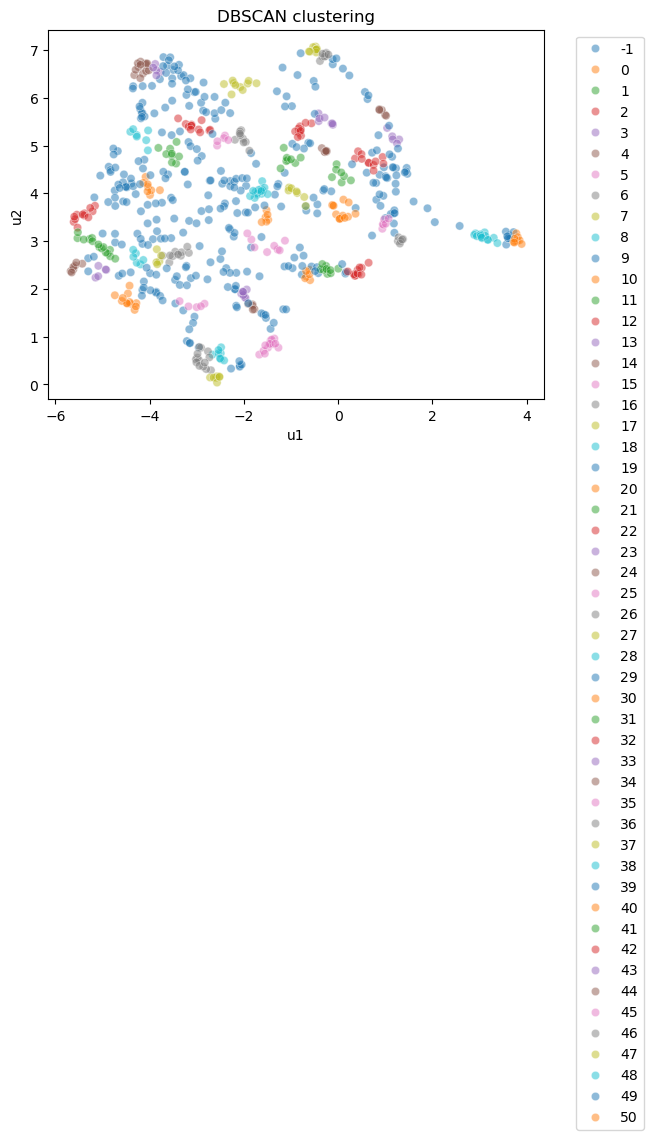

In [49]:
plt.figure() 
sbn.scatterplot(data=df, x='u1', y='u2', hue='label', alpha=0.5, palette='tab10')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('DBSCAN clustering')
plt.show()

In [50]:
(clus.labels_ == -1).sum()

np.int64(285)

# create cluster similarity assignment function 

1. Train an MLP to predict cluster from `z` 

2. create function that maps from native gene space to cluster assignment c ~ mlp(encoder(x))

In [51]:
mlp = MLP(12, 100, out_channels=len(clus.labels_)-1, layers=1, dropout=0.25).cuda()

in_cluster = clus.labels_ != -1
x_clus = X[in_cluster] 
print(len(x_clus))

optim = torch.optim.Adam(mlp.parameters(), lr=5e-4) 
crit = torch.nn.CrossEntropyLoss()
yy = torch.tensor(clus.labels_[in_cluster], dtype=torch.long).cuda()
zz = torch.tensor(z[in_cluster], dtype=torch.float32).cuda()

for epoch in range(250): 

    model.train()
    for ixs in torch.split(torch.arange(len(zz)), 32): 
        optim.zero_grad() 

        pred = mlp(zz[ixs])
        loss = crit(pred, yy[ixs])
        loss.backward()
        optim.step()

    with torch.no_grad(): 
        model.eval() 
        pred = mlp(zz)
        acc = (pred.argmax(dim=-1) == yy).float().mean().item()
        loss = crit(pred, yy).item()

    print(f'Epoch {epoch}: loss = {loss:.4f}, acc = {acc:.4f}', end='\r')


432


In [52]:

class func(torch.nn.Module): 
    def __init__(self, vae, mlp, cluster_idx): 
        super().__init__()
        self.vae = vae.eval()
        self.mlp = mlp.eval()
        self.cluster_idx = cluster_idx

    def forward(self, x):

        z = self.vae.encode(x)[0]
        c = self.mlp(z).softmax(-1)[:, self.cluster_idx].view(-1,1)

        return c
    

# perform shap to predict cluster assignments 

In [53]:
device = 'cpu'
attribution = 'ig'
n_top_genes = 50

In [54]:
X = expr.iloc[:, 1:].values
X = torch.tensor(X, dtype=torch.float32).to(device)

In [55]:
for clus_idx in range(len(set(clus.labels_)) - 1):

    f = func(model, mlp, cluster_idx=clus_idx).to(device)

    cluster_ixs = np.where(clus.labels_ == clus_idx)[0]

    cluster_x = X[cluster_ixs, :].to(device)
    cluster_target = torch.ones(len(cluster_ixs), dtype=torch.float32).to(device)

    z0 = torch.zeros(1,12).to(device)
    x0 = model.decode(z0)
    integrated_gradients = IntegratedGradients(f)
    importance_scores = integrated_gradients.attribute(cluster_x, baselines=x0, n_steps=200).detach().cpu().numpy()

    scores = importance_scores.mean(0)
    argixs = np.argsort( scores )
    gene_order = expr.columns[1:]

    # sort high to low 
    argixs = argixs[::-1]

    sorted_scores = scores[argixs]
    sorted_genes = list(gene_order[argixs])

    # prepare pre-ranked list for GSEA
    rnk = pd.DataFrame({
        'gene': sorted_genes,
        'score': sorted_scores
    }).set_index('gene')

    # run prerank GSEA with Reactome_2016
    prerank_res = gp.prerank(
        rnk=rnk,
        gene_sets=["Reactome_2016"],
        outdir=None,         # don't write files to disk
        permutation_num=1000, 
        seed=0
    )


    print('#' * 20)
    print(f'Cluster {clus_idx} - {len(cluster_ixs)} samples')
    print('enriched GO terms (alpha = 0.05 adjusted)')
    print()
    print( prerank_res.res2d[lambda x: x['FDR q-val'] < 0.05].Term.values.tolist() ) 
    print()


####################
Cluster 0 - 13 samples
enriched GO terms (alpha = 0.05 adjusted)

['Reactome_2016__Platelet degranulation Homo sapiens R-HSA-114608', 'Reactome_2016__Platelet activation, signaling and aggregation Homo sapiens R-HSA-76002', 'Reactome_2016__Response to elevated platelet cytosolic Ca2+ Homo sapiens R-HSA-76005', 'Reactome_2016__Hemostasis Homo sapiens R-HSA-109582']

####################
Cluster 1 - 7 samples
enriched GO terms (alpha = 0.05 adjusted)

['Reactome_2016__Platelet activation, signaling and aggregation Homo sapiens R-HSA-76002', 'Reactome_2016__Semaphorin interactions Homo sapiens R-HSA-373755', 'Reactome_2016__Platelet degranulation Homo sapiens R-HSA-114608', 'Reactome_2016__Response to elevated platelet cytosolic Ca2+ Homo sapiens R-HSA-76005']

####################
Cluster 2 - 11 samples
enriched GO terms (alpha = 0.05 adjusted)

['Reactome_2016__Eukaryotic Translation Elongation Homo sapiens R-HSA-156842', 'Reactome_2016__Peptide chain elongation Hom

In [121]:
prerank_res.res2d.sort_values('FDR q-val')

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
15,prerank,Reactome_2016__S Phase Homo sapiens R-HSA-69242,-0.514779,-1.599019,0.013889,0.166092,0.651,9/28,17.16%,MCM6;SMC1A;MCM5;CDT1;MCM3;PCNA;MCM2;FEN1;CUL1
14,prerank,Reactome_2016__Synthesis of DNA Homo sapiens R...,-0.534993,-1.604144,0.02008,0.175798,0.634,6/23,10.84%,MCM6;MCM5;CDT1;MCM3;PCNA;MCM2
13,prerank,Reactome_2016__DNA Replication Homo sapiens R-...,-0.534993,-1.604144,0.02008,0.175798,0.634,6/23,10.84%,MCM6;MCM5;CDT1;MCM3;PCNA;MCM2
12,prerank,Reactome_2016__Orc1 removal from chromatin Hom...,-0.5951,-1.622504,0.016495,0.194828,0.59,5/17,10.84%,MCM6;MCM5;CDT1;MCM3;MCM2
11,prerank,Reactome_2016__Regulation of DNA replication H...,-0.5951,-1.622504,0.016495,0.194828,0.59,5/17,10.84%,MCM6;MCM5;CDT1;MCM3;MCM2
...,...,...,...,...,...,...,...,...,...,...
293,prerank,Reactome_2016__Transport of Mature mRNA derive...,-0.213966,-0.583634,0.953846,1.0,1.0,2/17,10.72%,ALYREF;SLU7
294,prerank,Reactome_2016__TP53 Regulates Metabolic Genes ...,0.190545,0.568632,0.973085,1.0,1.0,3/24,12.16%,DDIT4;COX4I1;COX7C
297,prerank,Reactome_2016__Hedgehog 'off' state Homo sapie...,-0.207714,-0.550335,0.961847,1.0,1.0,8/15,36.28%,CUL1;ADCY7;NUMB;PRKACA;PSMB9;IFT57;RPS27A;PRKAR1A
299,prerank,Reactome_2016__DNA Double-Strand Break Repair ...,-0.192834,-0.521854,0.982353,1.0,1.0,16/16,80.88%,PCNA;FEN1;UIMC1;PRKDC;RPS27A;PARP1;KPNA2;POLD2...


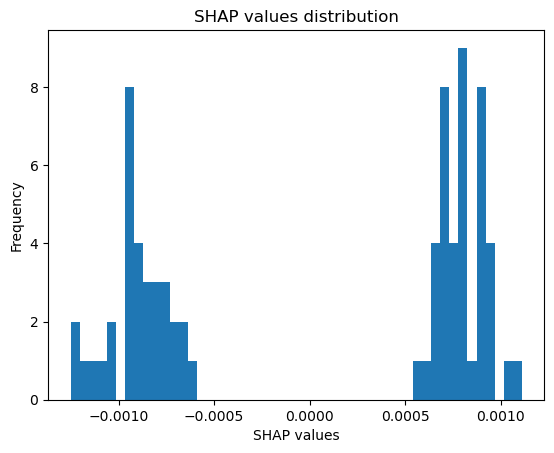

In [19]:
plt.figure()
plt.hist(importance_scores[:,0].ravel(), bins=50)
#plt.yscale('log')
plt.xlabel('SHAP values')
plt.ylabel('Frequency')
plt.title('SHAP values distribution')
plt.show()

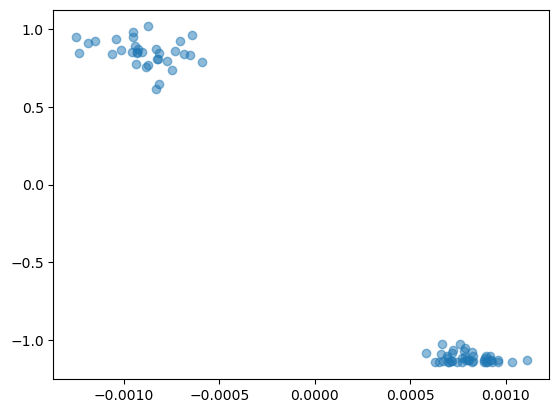

In [21]:
plt.figure()
plt.plot(importance_scores[:,0].ravel(), cluster_x[:,0].ravel(), 'o', alpha=0.5)

In [250]:
enr_bg.results.head(10)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2016,Disease Homo sapiens R-HSA-1643685,0.002309,0.102884,0,0,9.095238,55.217523,ADAMTS2;JAG1;SDC4;CD9
1,Reactome_2016,TNFs bind their physiological receptors Homo s...,0.003494,0.102884,0,0,42.304348,239.306583,TNFRSF18;TNFRSF4
2,Reactome_2016,TNFR2 non-canonical NF-kB pathway Homo sapiens...,0.005734,0.102884,0,0,28.173913,145.416894,TNFRSF18;TNFRSF4
3,Reactome_2016,Diseases of glycosylation Homo sapiens R-HSA-3...,0.011675,0.102884,0,0,16.869565,75.074545,ADAMTS2;SDC4
4,Reactome_2016,Collagen biosynthesis and modifying enzymes Ho...,0.011675,0.102884,0,0,16.869565,75.074545,ADAMTS2;COL4A5
5,Reactome_2016,Extracellular matrix organization Homo sapiens...,0.012635,0.102884,0,0,5.271709,23.044245,ADAMTS2;SDC4;COL4A5;ELANE
6,Reactome_2016,Collagen formation Homo sapiens R-HSA-1474290,0.019408,0.102884,0,0,12.024845,47.402564,ADAMTS2;COL4A5
7,Reactome_2016,Sperm:Oocyte Membrane Binding Homo sapiens R-H...,0.025000,0.102884,0,0,inf,inf,CD9
8,Reactome_2016,Fertilization Homo sapiens R-HSA-1187000,0.025000,0.102884,0,0,inf,inf,CD9
9,Reactome_2016,Reproduction Homo sapiens R-HSA-1474165,0.025000,0.102884,0,0,inf,inf,CD9


In [235]:
enr_bg.results.head()

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2016,Collagen degradation Homo sapiens R-HSA-1442490,0.012327,0.446153,0,0,6.208333,27.291529,MMP2;MMP19;PRSS2;ELANE
1,Reactome_2016,Degradation of the extracellular matrix Homo s...,0.016149,0.446153,0,0,4.253589,17.549928,MMP2;MMP19;LAMC1;PRSS2;ELANE
2,Reactome_2016,Aflatoxin activation and detoxification Homo s...,0.027783,0.446153,0,0,18.346939,65.742952,ACY3;MGST1
3,Reactome_2016,Extracellular matrix organization Homo sapiens...,0.029062,0.446153,0,0,2.521739,8.922745,ADAMTS2;CEACAM6;MMP2;COL4A5;MMP19;LAMC1;PRSS2;...
4,Reactome_2016,Rho GTPase cycle Homo sapiens R-HSA-194840,0.051958,0.446153,0,0,9.163265,27.098654,ARHGAP22;DLC1


In [5]:
expr = pd.read_csv('../data/aml_expr.csv')
X = expr.iloc[:, 1:].values

In [6]:
z = f(X) 
z.shape

(717, 12)

In [7]:
reducer = umap.UMAP() 
u = reducer.fit_transform(z)

df = pd.DataFrame(z, columns=[f'Z{i}' for i in range(z.shape[1])]).assign(u1=u[:, 0], u2=u[:, 1])
df.head()

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,u1,u2
0,0.401562,-3.661939,2.575311,2.457817,-1.251617,-1.782826,-0.470557,-3.665357,-0.088706,-2.171198,0.704312,-2.857019,0.449669,1.371819
1,1.234304,-2.859714,4.125150,3.190236,-0.199223,0.966852,1.227564,-1.557224,3.192834,1.886375,-3.095883,-2.409158,-0.496387,2.344685
2,3.871517,0.680781,0.598997,2.336961,-0.502269,0.776640,-0.910013,-1.052591,-0.575642,0.158573,2.413478,2.692233,-2.158190,-3.149235
3,-2.303520,-2.616863,0.276941,-2.032356,-0.722825,-0.023454,2.114030,3.916564,-0.155495,2.661231,-2.392552,1.409396,-2.200017,1.520345
4,1.332419,0.540172,-1.022666,-3.386779,-1.451896,0.752559,-2.743731,0.388017,-1.432925,1.060596,0.525343,0.941352,1.709406,-1.385198


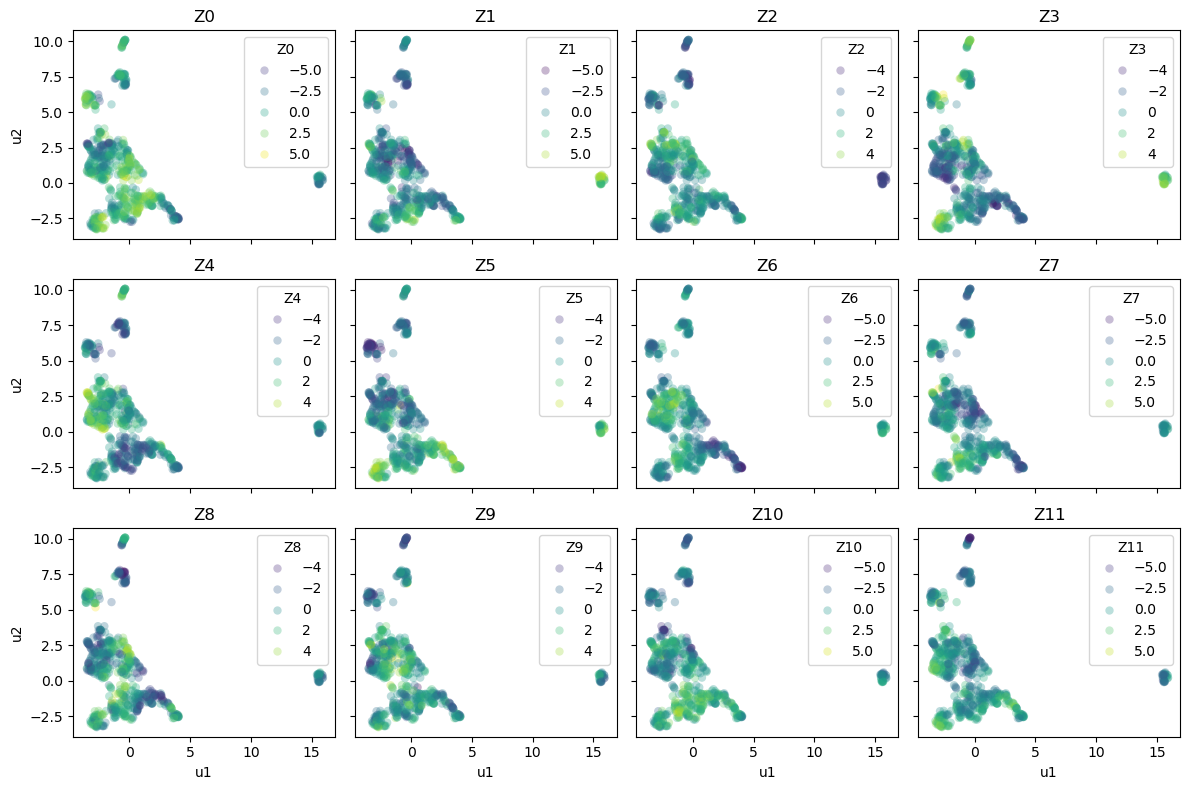

In [19]:
f,axes = plt.subplots(3,4, figsize=(12, 8), sharex=True, sharey=True)

for i in range(12):
    sbn.scatterplot(data=df, x='u1', y='u2', hue=f'Z{i}', linewidth=0, alpha=0.3, ax=axes.flat[i], palette='viridis')
    axes.flat[i].set_title(f'Z{i}')

plt.tight_layout()
plt.show() 

In [ ]:
background_mask = np.random.rand(X.shape[0]) < 0.1
rest_mask = ~background_mask
explainer = shap.KernelExplainer(f, X[background_mask, :])
shap_values = explainer.shap_values(X[rest_mask, :], nsamples=250)

In [70]:
shap_values = explainer.shap_values(X[rest_mask, :], nsamples=250)

  0%|          | 0/645 [00:00<?, ?it/s]

In [71]:
shap_values.shape # (n_samples, n_features, n_latent)

(645, 1000, 12)

In [72]:
genes = expr.columns[1:]

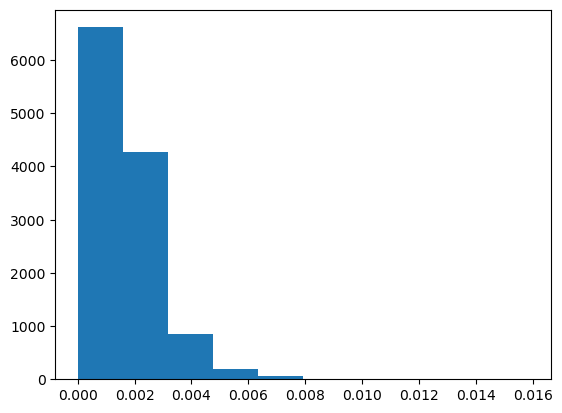

In [84]:
plt.figure()
plt.hist( np.abs(shap_values[:, :, :]).mean(axis=0).ravel() ) 
plt.show() 

In [ ]:

t = 0.004

for i in range(12): 
    print('########################'*2)
    print('########################'*2)
    print('latent dim:', i)
    print() 
    df = pd.DataFrame({'abs_mean_shap':np.abs( shap_values[:, :, i] ).mean(axis=0) , 'genes':genes})
    df = df.sort_values(by='abs_mean_shap', ascending=False)

    genelist = df[lambda x: x.abs_mean_shap >= t].genes.values.tolist()
    print('n genes:', len(genelist))
    background = df.genes.values.tolist()

    enr_bg = gp.enrichr(gene_list=genelist,
                    gene_sets=['Reactome_2016'],
                    # organism='human', # organism argment is ignored because user input a background
                    background=background,
                    outdir=None, # don't write to disk
                    )

    print(enr_bg.results[lambda x: x['Adjusted P-value'] < 0.1].Term.values) 

################################################
################################################
latent dim: 0

n genes: 45
[]
################################################
################################################
latent dim: 1

n genes: 45
['DAP12 interactions Homo sapiens R-HSA-2172127'
 'Downstream signal transduction Homo sapiens R-HSA-186763'
 'Downstream signaling of activated FGFR2 Homo sapiens R-HSA-5654696'
 'Downstream signaling of activated FGFR4 Homo sapiens R-HSA-5654716'
 'Downstream signaling of activated FGFR3 Homo sapiens R-HSA-5654708'
 'Downstream signaling of activated FGFR1 Homo sapiens R-HSA-5654687'
 'DAP12 signaling Homo sapiens R-HSA-2424491'
 'NGF signalling via TRKA from the plasma membrane Homo sapiens R-HSA-187037'
 'Signaling by SCF-KIT Homo sapiens R-HSA-1433557'
 'Signaling by FGFR3 Homo sapiens R-HSA-5654741'
 'Signaling by FGFR4 Homo sapiens R-HSA-5654743'
 'Signaling by FGFR1 Homo sapiens R-HSA-5654736'
 'Signaling by FGFR2 Homo sapiens R-